In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ============================================================== 
# 1. Load and preprocess with better data cleaning
# ============================================================== 

df = pd.read_csv("C:/Users/jvgat/Downloads/Hazard/df_after_feature_engineering.csv")

print(df.dtypes)

# Print basic info
print(f"Dataset shape: {df.shape}")

# --- Parse datetime columns ---
date_cols = [
    'eu_published', 'dateUpdated_eu', 'published_date',
    'published_date_jvn', 'lastmodified_nvd', 'published_nvd'
]
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)
        df[col] = df[col].dt.tz_convert(None)

cve_id             object
cve_year            int64
published_date     object
base_score        float64
nvd_present          bool
                   ...   
tfidf_95          float64
tfidf_96          float64
tfidf_97          float64
tfidf_98          float64
tfidf_99          float64
Length: 188, dtype: object
Dataset shape: (149411, 188)


In [14]:
# ==============================================================
# 2. Construct proper survival dataset
# ==============================================================

# Ensure datetime columns are actually datetimes
date_cols = ['eu_published', 'published_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Convert all timezone-aware datetimes to timezone-naive (UTC dropped)
for col in date_cols:
    if pd.api.types.is_datetime64tz_dtype(df[col]):
        df[col] = df[col].dt.tz_localize(None)

# Also make pd.Timestamp.today() timezone-naive to match
today = pd.Timestamp.now(tz=None)

# Split into KEV and non-KEV
df_kev = df.loc[df['published_date'].notnull()].copy()
df_non_kev = df.loc[df['published_date'].isnull()].copy()

print(f"KEV CVEs: {len(df_kev)}, Non-KEV CVEs: {len(df_non_kev)}")

# For KEV entries: duration = time from publication to KEV addition
df_kev['duration'] = (df_kev['published_date'] - df_kev['eu_published']).dt.total_seconds() / (3600 * 24)
df_kev['event'] = 1

# For non-KEV entries: duration = time from publication to today (censored)
df_non_kev['duration'] = (today - df_non_kev['eu_published']).dt.total_seconds() / (3600 * 24)
df_non_kev['event'] = 0

# Combine
df_combined = pd.concat([df_kev, df_non_kev], ignore_index=True)

# Remove invalid durations
df_combined = df_combined[df_combined['duration'] > 0]
df_combined = df_combined[df_combined['duration'] < 365 * 5]  # < 5 years

print(f"After cleaning - KEV: {(df_combined['event'] == 1).sum()}, Non-KEV: {(df_combined['event'] == 0).sum()}")


KEV CVEs: 148085, Non-KEV CVEs: 1326
After cleaning - KEV: 58321, Non-KEV: 1048


In [15]:
# Features to use
features = ['base_score', 'repo_publication_lag', 'cross_listing_count',
            'cross_listing_variance', 'cwe_risk_factor']

# Check that features exist
missing = [f for f in features if f not in df_combined.columns]
if missing:
    raise ValueError(f"Missing feature columns in df_combined: {missing}")

# Make a working copy and drop rows with missing duration/event
df_model = df_combined.dropna(subset=['duration', 'event']).copy()

# Extract feature matrix and target (leave duration/event in the DataFrame for lifelines)
X = df_model[features].copy()
y_duration = df_model['duration'].values
y_event = df_model['event'].values

# Impute missing feature values (median)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features, index=X.index)

# Scale features (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=features, index=X.index)

# Combine with duration/event for lifelines
df_for_lifelines = pd.concat([X_scaled, df_model[['duration', 'event']]], axis=1)

# Train/test split (stratify on event to keep censoring ratio)
df_train, df_test = train_test_split(
    df_for_lifelines, test_size=0.25, random_state=42, stratify=df_for_lifelines['event']
)

# Fit CoxPH
cph = CoxPHFitter()
cph.fit(df_train, duration_col='duration', event_col='event', show_progress=False)

# Print summary (coefficients, p-values, etc.)
print("\nCoxPH model summary (train):")
display(cph.summary)  # in Jupyter this shows a nice table; you can use print(cph.summary) if not in notebook

# Concordance index (train and test)
# Use predicted partial hazards as risk scores (higher => higher hazard/earlier event)
train_pred = cph.predict_partial_hazard(df_train).values.ravel()
test_pred  = cph.predict_partial_hazard(df_test).values.ravel()

cindex_train = concordance_index(df_train['duration'], -train_pred, df_train['event'])
cindex_test  = concordance_index(df_test['duration'], -test_pred, df_test['event'])
# Note: concordance_index expects higher score => longer survival by default; we invert with -pred so higher => longer.

print(f"\nConcordance index (train): {cindex_train:.4f}")
print(f"Concordance index (test) : {cindex_test:.4f}")

# Check proportional hazards assumption (prints warnings / test results)
print("\nChecking proportional hazards assumption (Schoenfeld residuals tests):")
# set show_plots=True if you want the diagnostics plotted; False for text-only
cph.check_assumptions(df_train, p_value_threshold=0.05, show_plots=False)


CoxPH model summary (train):


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
base_score,-0.003866,0.996142,0.005110,-0.013880,0.006149,0.986216,1.006167,0.0,-0.756610,4.492833e-01,1.154303
repo_publication_lag,-2.809389,0.060242,0.061870,-2.930652,-2.688125,0.053362,0.068008,0.0,-45.407724,0.000000e+00,inf
cross_listing_count,0.097226,1.102109,0.003246,0.090864,0.103587,1.095120,1.109143,0.0,29.953629,3.946271e-197,652.439345
cross_listing_variance,2.785061,16.200806,0.061677,2.664176,2.905946,14.356117,18.282529,0.0,45.155513,0.000000e+00,inf
cwe_risk_factor,-0.000770,0.999230,0.005302,-0.011163,0.009623,0.988899,1.009669,0.0,-0.145220,8.845369e-01,0.177006



Concordance index (train): 0.9151
Concordance index (test) : 0.9152

Checking proportional hazards assumption (Schoenfeld residuals tests):
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 44526 total observations, 786 right-censored observations>
         test_name = proportional_hazard_test

---
                             test_statistic      p  -log2(p)
base_score             km              0.71   0.40      1.32
                       rank            0.71   0.40      1.32
cross_listing_count    km           1672.59 <0.005       inf
                       rank         1672.70 <0.005       inf
cross_listing_variance km            273.06 <0.005    201.35
                       rank          273.05 <0.005    201.34
cwe_risk_factor        km              2.65   0.10      3.27
                       rank            2.65   0.10      3.28
repo_publication_lag   km            255.12 <0.005    188.36
                       rank          255.07 <0.005    188.33



1. Variable 'repo_publication_lag' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'repo_publication_lag' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'repo_publication_lag' using pd.cut, and then specify it in
`strata=['repo_publication_lag', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'cross_listing_count' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'cross_listing_count' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional for

[]

In [17]:
# ---------------------------
# Stratified Cox: corrected check_assumptions usage
# ---------------------------

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

# Features to keep as covariates (non-strata). These are the only columns that will have coefficients.
covariates = ['base_score', 'cwe_risk_factor']

# Build model dataframe (drop rows with missing duration/event or covariates)
df_model = df_combined[covariates + 
                       ['repo_publication_lag', 'cross_listing_count', 'cross_listing_variance',
                        'duration', 'event']].dropna().copy()

# Create bins for stratification (use qcut to get roughly equal-sized strata)
df_model['repo_publication_lag_bin'] = pd.qcut(df_model['repo_publication_lag'], q=4, duplicates='drop')
df_model['cross_listing_count_bin'] = pd.qcut(df_model['cross_listing_count'], q=4, duplicates='drop')
df_model['cross_listing_variance_bin'] = pd.qcut(df_model['cross_listing_variance'], q=4, duplicates='drop')

# Ensure index is unique (required by lifelines)
df_model = df_model.reset_index(drop=True)

# --- IMPORTANT: build the exact dataframe we will pass to .fit() ---
df_fit = df_model[['duration', 'event'] + covariates + 
                  ['repo_publication_lag_bin', 'cross_listing_count_bin', 'cross_listing_variance_bin']].copy()

# Fit stratified Cox model
cph_strat = CoxPHFitter()
cph_strat.fit(
    df_fit,
    duration_col='duration',
    event_col='event',
    strata=['repo_publication_lag_bin', 'cross_listing_count_bin', 'cross_listing_variance_bin']
)

# Print summary
cph_strat.print_summary()

# Concordance index (use the same df_fit)
# For predict_partial_hazard, pass only the covariate columns (and lifelines will handle strata)
risk_scores = cph_strat.predict_partial_hazard(df_fit).values.ravel()
c_index = concordance_index(df_fit['duration'], -risk_scores, df_fit['event'])
print(f"\nConcordance Index (on df_fit): {c_index:.4f}")

# Now correctly call check_assumptions on the exact training frame used for fit
print("\nChecking proportional hazards assumptions (on the same data used for fit):")
cph_strat.check_assumptions(df_fit, p_value_threshold=0.05, show_plots=False)



<lifelines.CoxPHFitter: fitted with 51069 total observations, 188 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                   strata = ['repo_publication_lag_bin', 'cross_listing_count_bin', 'cross_listing_variance_bin']
      baseline estimation = breslow
   number of observations = 51069
number of events observed = 50881
   partial log-likelihood = -430987.82
         time fit was run = 2025-11-06 01:57:26 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
base_score      -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
cwe_risk_factor -1.07      0.34      0.49           -2.02           -0.11                0.13                0.90

                 cmp to     z    p  -log2(p)
covariate                                   
base_score         0.00 -1.58 0.11      3.14
cwe_risk_factor    0.00 -2.18 0.03      5.11
---
Concordance = 0.51
Partial AIC = 861979.65
log-likelihood ratio test = 9.42 on 2 df
-log2(p) of ll-ratio test = 6.79


Concordance Index (on df_fit): 0.5199

Checking proportional hazards assumptions (on the same data used for fit):
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 51069 total observations, 188 right-censored observations>
         test_name = proportional_hazard_test

---
                      test_statistic    p  -log2(p)
base_score      km              4.97 0.03      5.28
                rank            4.93 0.03      5.24
cwe_risk_factor km              1.58 0.21      2.26
                rank            1.53 0.22      2.21



1. Variable 'base_score' failed the non-proportional test: p-value is 0.0257.

   Advice 1: the functional form of the variable 'base_score' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'base_score' using pd.cut, and then specify it in
`strata=['base_score', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumpti

[]

In [18]:
# ===========================================
# Option B: Stratify by binned base_score
# ===========================================

# Bin base_score roughly following CVSS v3 categories
bins = [0, 4.0, 7.0, 9.0, 10.0]
labels = ['Low', 'Medium', 'High', 'Critical']
df_model['base_score_bin'] = pd.cut(df_model['base_score'], bins=bins, labels=labels, include_lowest=True)

# Build new fit dataframe
df_fit_binned = df_model[['duration', 'event', 'cwe_risk_factor',
                          'repo_publication_lag_bin', 'cross_listing_count_bin', 
                          'cross_listing_variance_bin', 'base_score_bin']].copy()

# Fit stratified model (stratify on base_score_bin)
cph_strat2 = CoxPHFitter()
cph_strat2.fit(
    df_fit_binned,
    duration_col='duration',
    event_col='event',
    strata=['repo_publication_lag_bin', 'cross_listing_count_bin', 
            'cross_listing_variance_bin', 'base_score_bin']
)

cph_strat2.print_summary()

# Check assumptions again
print("\nChecking PH assumptions for the stratified model:")
cph_strat2.check_assumptions(df_fit_binned, p_value_threshold=0.05, show_plots=False)


<lifelines.CoxPHFitter: fitted with 51069 total observations, 188 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                   strata = ['repo_publication_lag_bin', 'cross_listing_count_bin', 'cross_listing_variance_bin', 'base_score_bin']
      baseline estimation = breslow
   number of observations = 51069
number of events observed = 50881
   partial log-likelihood = -375728.79
         time fit was run = 2025-11-06 02:00:17 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
cwe_risk_factor -1.04      0.35      0.48           -1.99           -0.10                0.14                0.91

                 cmp to     z    p  -log2(p)
covariate                                   
cwe_risk_factor    0.00 -2.16 0.03      5.02
---
Concordance = 0.51
Partial AIC = 751459.58
log-likelihood ratio test = 4.98 on 1 df
-log2(p) of ll-ratio test = 5.29


Checking PH assumptions for the stratified model:
Proportional hazard assumption looks okay.


[]

Rows used for stratified fit: 59369

Stratified CoxPH model summary:


<lifelines.CoxPHFitter: fitted with 59369 total observations, 1048 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                   strata = ['repo_publication_lag_bin', 'cross_listing_count_bin', 'cross_listing_variance_bin', 'base_score_bin']
      baseline estimation = breslow
   number of observations = 59369
number of events observed = 58321
   partial log-likelihood = -437131.00
         time fit was run = 2025-11-06 02:05:11 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
cwe_risk_factor  0.47      1.60      0.39           -0.30            1.24                0.74                3.46

                 cmp to    z    p  -log2(p)
covariate                                  
cwe_risk_factor    0.00 1.19 0.23      2.09
---
Concordance = 0.49
Partial AIC = 874264.00
log-likelihood ratio test = 1.34 on 1 df
-log2(p) of ll-ratio test = 2.02


Concordance Index (on training frame): 0.4865

Checking proportional hazards assumptions for the stratified model (should only test non-strata covariates):
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 59369 total observations, 1048 right-censored observations>
         test_name = proportional_hazard_test

---
                      test_statistic      p  -log2(p)
cwe_risk_factor km             18.50 <0.005     15.85
                rank           21.36 <0.005     18.00



1. Variable 'cwe_risk_factor' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'cwe_risk_factor' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'cwe_risk_factor' using pd.cut, and then specify it in
`strata=['cwe_risk_factor', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional

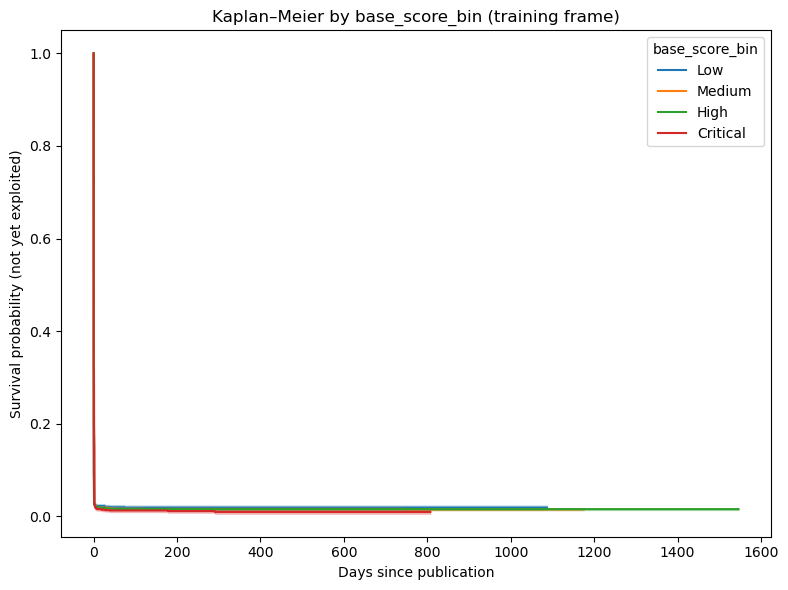

In [21]:
# ---------------------------
# Finish model: build bins, fit stratified Cox, evaluate & plot
# ---------------------------

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index

# 1) Build a fresh df_model from df_combined so we keep original continuous values for binning
model_cols = ['base_score', 'repo_publication_lag', 'cross_listing_count',
              'cross_listing_variance', 'cwe_risk_factor', 'duration', 'event']

df_model = df_combined[model_cols].copy()

# 2) Impute missing feature values (median) for the numeric columns before binning
num_cols = ['base_score', 'repo_publication_lag', 'cross_listing_count', 'cross_listing_variance', 'cwe_risk_factor']
imputer2 = SimpleImputer(strategy='median')
df_model[num_cols] = imputer2.fit_transform(df_model[num_cols])

# 3) Create bins/strata for the previously-problematic continuous variables
# Use qcut for roughly equal-sized strata; duplicates='drop' prevents errors when data is skewed
df_model['repo_publication_lag_bin'] = pd.qcut(df_model['repo_publication_lag'], q=4, duplicates='drop')
df_model['cross_listing_count_bin'] = pd.qcut(df_model['cross_listing_count'], q=4, duplicates='drop')
df_model['cross_listing_variance_bin'] = pd.qcut(df_model['cross_listing_variance'], q=4, duplicates='drop')

# 4) Bin base_score into CVSS-like categories (Low/Medium/High/Critical)
bins = [0.0, 4.0, 7.0, 9.0, 10.0]
labels = ['Low', 'Medium', 'High', 'Critical']
# If some base_score values are outside [0,10] due to imputation/dirty data, clip first
df_model['base_score_clipped'] = df_model['base_score'].clip(lower=0.0, upper=10.0)
df_model['base_score_bin'] = pd.cut(df_model['base_score_clipped'], bins=bins, labels=labels, include_lowest=True)

# 5) Build the exact DataFrame we will pass to .fit()
# We'll keep only the covariate(s) we want coefficients for (here: cwe_risk_factor),
# and the stratification columns (which are not estimated as coefficients).
df_fit_binned = df_model[['duration', 'event', 'cwe_risk_factor',
                          'repo_publication_lag_bin', 'cross_listing_count_bin',
                          'cross_listing_variance_bin', 'base_score_bin']].copy()

# Drop any rows with missing strata labels (qcut/pd.cut can create NaNs if edges had ties)
df_fit_binned = df_fit_binned.dropna().reset_index(drop=True)

print(f"Rows used for stratified fit: {len(df_fit_binned)}")

# 6) Fit stratified Cox model (strata = the three earlier bins + base_score_bin)
cph_strat2 = CoxPHFitter()
cph_strat2.fit(
    df_fit_binned,
    duration_col='duration',
    event_col='event',
    strata=['repo_publication_lag_bin', 'cross_listing_count_bin',
            'cross_listing_variance_bin', 'base_score_bin']
)

# 7) Output: summary and concordance
print("\nStratified CoxPH model summary:")
cph_strat2.print_summary()

# Concordance index on the same frame used for fit (df_fit_binned)
risk_scores = cph_strat2.predict_partial_hazard(df_fit_binned).values.ravel()
c_index = concordance_index(df_fit_binned['duration'], -risk_scores, df_fit_binned['event'])
print(f"\nConcordance Index (on training frame): {c_index:.4f}")

# 8) Correctly call check_assumptions using the exact training frame used for fit
print("\nChecking proportional hazards assumptions for the stratified model (should only test non-strata covariates):")
cph_strat2.check_assumptions(df_fit_binned, p_value_threshold=0.05, show_plots=False)

# 9) Kaplan-Meier curves by base_score_bin for visualization of different baselines
kmf = KaplanMeierFitter()
plt.figure(figsize=(8,6))

for label in df_fit_binned['base_score_bin'].cat.categories:
    mask = df_fit_binned['base_score_bin'] == label
    if mask.sum() == 0:
        continue
    kmf.fit(df_fit_binned.loc[mask, 'duration'], event_observed=df_fit_binned.loc[mask, 'event'], label=str(label))
    kmf.plot(ci_show=True)

plt.title("Kaplan–Meier by base_score_bin (training frame)")
plt.xlabel("Days since publication")
plt.ylabel("Survival probability (not yet exploited)")
plt.legend(title="base_score_bin")
plt.tight_layout()
plt.show()

# 10) (Optional) Save the fitted model for later reuse
# cph_strat2.save("coxph_stratified_base_and_bins.pkl")


In [22]:
# 1) Bin cwe_risk_factor (roughly quartiles or use domain-specific thresholds)
df_fit_binned['cwe_risk_factor_bin'] = pd.qcut(df_fit_binned['cwe_risk_factor'], q=4, duplicates='drop')

# 2) Drop any rows with missing bins (if any due to qcut edge cases)
df_fit_binned = df_fit_binned.dropna(subset=['cwe_risk_factor_bin']).reset_index(drop=True)

# 3) Fit fully stratified CoxPH (strata now includes cwe_risk_factor_bin)
cph_strat_final = CoxPHFitter()
cph_strat_final.fit(
    df_fit_binned,
    duration_col='duration',
    event_col='event',
    strata=['repo_publication_lag_bin', 
            'cross_listing_count_bin', 
            'cross_listing_variance_bin', 
            'base_score_bin',
            'cwe_risk_factor_bin']
)

# 4) Summary
print("\nFully stratified CoxPH model summary (cwe_risk_factor included as strata):")
cph_strat_final.print_summary()

# 5) Concordance index
risk_scores_final = cph_strat_final.predict_partial_hazard(df_fit_binned).values.ravel()
c_index_final = concordance_index(df_fit_binned['duration'], -risk_scores_final, df_fit_binned['event'])
print(f"\nConcordance Index (training frame): {c_index_final:.4f}")

# 6) Check PH assumptions (should now only test remaining non-stratified covariates)
print("\nChecking proportional hazards assumptions for fully stratified model:")
cph_strat_final.check_assumptions(df_fit_binned, p_value_threshold=0.05, show_plots=False)



Fully stratified CoxPH model summary (cwe_risk_factor included as strata):


<lifelines.CoxPHFitter: fitted with 59369 total observations, 1048 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                   strata = ['repo_publication_lag_bin', 'cross_listing_count_bin', 'cross_listing_variance_bin', 'base_score_bin', 'cwe_risk_factor_bin']
      baseline estimation = breslow
   number of observations = 59369
number of events observed = 58321
   partial log-likelihood = -361748.82
         time fit was run = 2025-11-06 02:06:20 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
cwe_risk_factor  0.24      1.28      0.50           -0.73            1.22                0.48                3.39

                 cmp to    z    p  -log2(p)
covariate                                  
cwe_risk_factor    0.00 0.49 0.62      0.68
---
Concordance = 0.50
Partial AIC = 723499.63
log-likelihood ratio test = 0.23 on 1 df
-log2(p) of ll-ratio test = 0.67


Concordance Index (training frame): 0.4865

Checking proportional hazards assumptions for fully stratified model:
Proportional hazard assumption looks okay.


[]

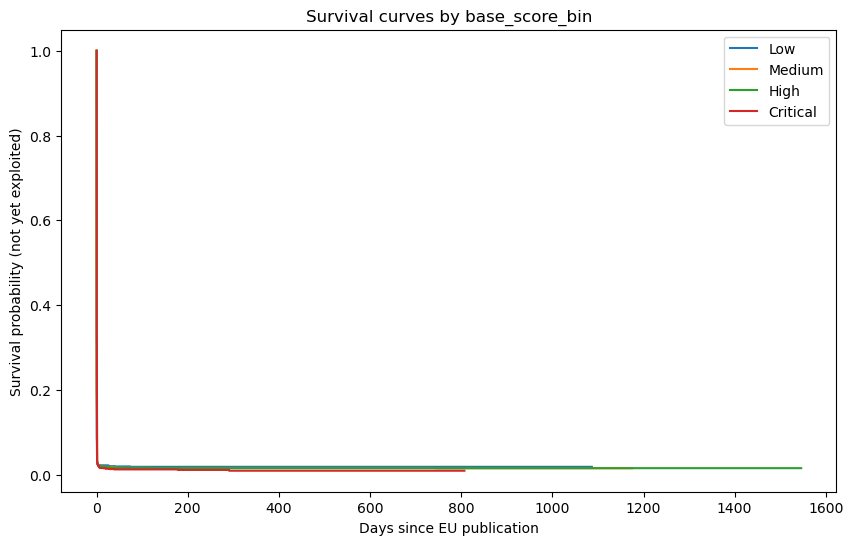

In [23]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
plt.figure(figsize=(10,6))

for name, grouped_df in df_fit_binned.groupby('base_score_bin'):
    kmf.fit(grouped_df['duration'], event_observed=grouped_df['event'], label=name)
    kmf.plot_survival_function(ci_show=False)

plt.title("Survival curves by base_score_bin")
plt.xlabel("Days since EU publication")
plt.ylabel("Survival probability (not yet exploited)")
plt.show()


In [25]:
df_new = df_fit_binned.copy()  # or any new dataset with same bin columns
risk_scores = cph_strat_final.predict_partial_hazard(df_new)
df_new['risk_score'] = risk_scores

print(df_new[['risk_score']].head())



   risk_score
0    0.999341
1    1.000656
2    1.000656
3    1.000656
4    0.999341
